# NVIDIA Stock Analysis and Prediction

## 1. Problem
> The goal of this project is to analyze the historical stock prices of NVIDIA, identify trends, and make predictions about future prices.

## 2. Dataset
This dataset provides a comprehensive collection of daily stock price data for Nvidia Corporation (NVDA), spanning a 20-year period from January 2, 2004, to January 1, 2024. Nvidia, a global leader in graphics processing units (GPUs) and AI technologies, has experienced exponential growth, particularly in recent years as it became a major player in artificial intelligence, gaming, and autonomous vehicles. This dataset captures key market movements and trends during Nvidia’s significant rise to prominence.

## 3. Evaluation
- Mean Squared Error (MSE)
- R-squared score (R2)

## 4. Features
- Date: The date of the stock price record.
- Open: The stock price at the beginning of the trading day.
- High: The highest price Nvidia stock reached during the day.
- Low: The lowest price Nvidia stock reached during the day.
- Close: The stock price at the end of the trading day.
- Volume: The total number of Nvidia shares traded during the day.

## Preparing the tools

In [3]:
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

import tensorflow as tf

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

## Load the Dataset

In [4]:
df = pd.read_csv('nvidia_stock_prices.csv')
df.head()

Date      Open      High       Low     Close      Volume
0  2004-01-02  0.196417  0.199083  0.192333  0.192333   436416000
1  2004-01-05  0.195250  0.199917  0.193500  0.198583   575292000
2  2004-01-06  0.198000  0.209417  0.197083  0.206667  1093344000
3  2004-01-07  0.204333  0.209500  0.202917  0.208500   673032000
4  2004-01-08  0.211083  0.212083  0.207250  0.209250   433752000

In [6]:
## Check for Missing Values
df.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [7]:
df.describe()

Open         High          Low        Close        Volume
count  5033.000000  5033.000000  5033.000000  5033.000000  5.033000e+03
mean      5.214671     5.308604     5.117086     5.217039  5.587962e+08
std       9.643976     9.811276     9.465058     9.644928  3.363408e+08
min       0.080583     0.083917     0.077500     0.078583  4.564400e+07
25%       0.344000     0.349000     0.336500     0.343250  3.482920e+08
50%       0.544000     0.552750     0.532500     0.542000  4.910920e+08
75%       5.233750     5.296500     5.125000     5.229000  6.816760e+08
max      50.216000    50.548000    49.411999    50.409000  5.088948e+09

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5033 non-null   object 
 1   Open    5033 non-null   float64
 2   High    5033 non-null   float64
 3   Low     5033 non-null   float64
 4   Close   5033 non-null   float64
 5   Volume  5033 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 236.1+ KB


## Exploratory Data Analysis

Uncover the trends present inside the dataset by doing some EDA.

In [5]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

for i in df.columns[1:5]:
    trace = go.Scatter(x=df[df.columns[0]], y=df[i])
    layout = go.Layout(title=i)
    fig = go.Figure(data=[trace], layout=layout)
    iplot(fig)

## Check the average monthly stocks in each year

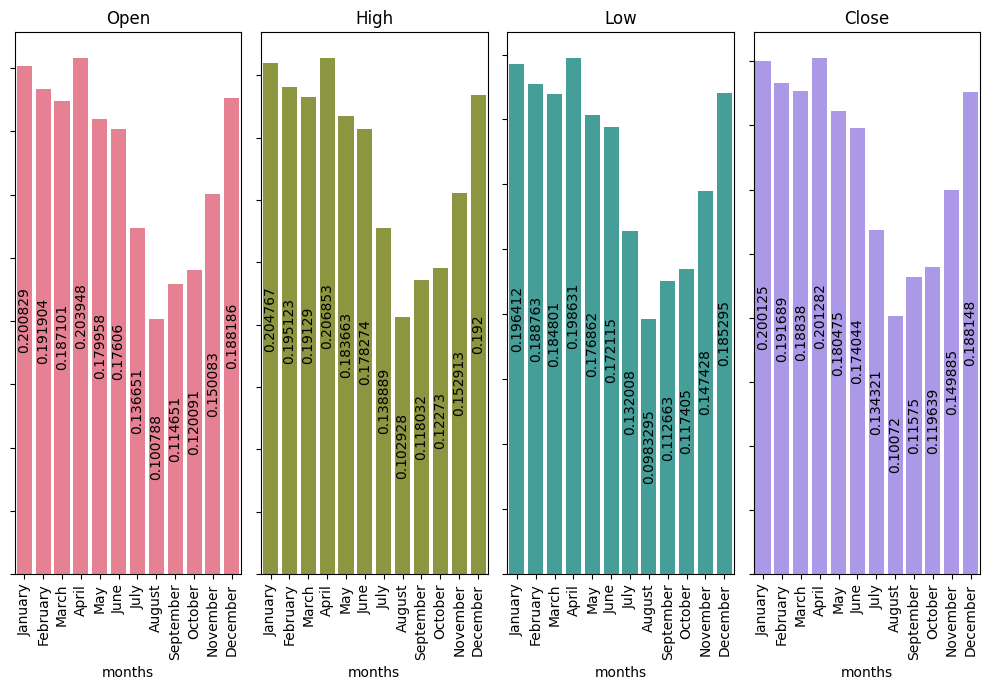

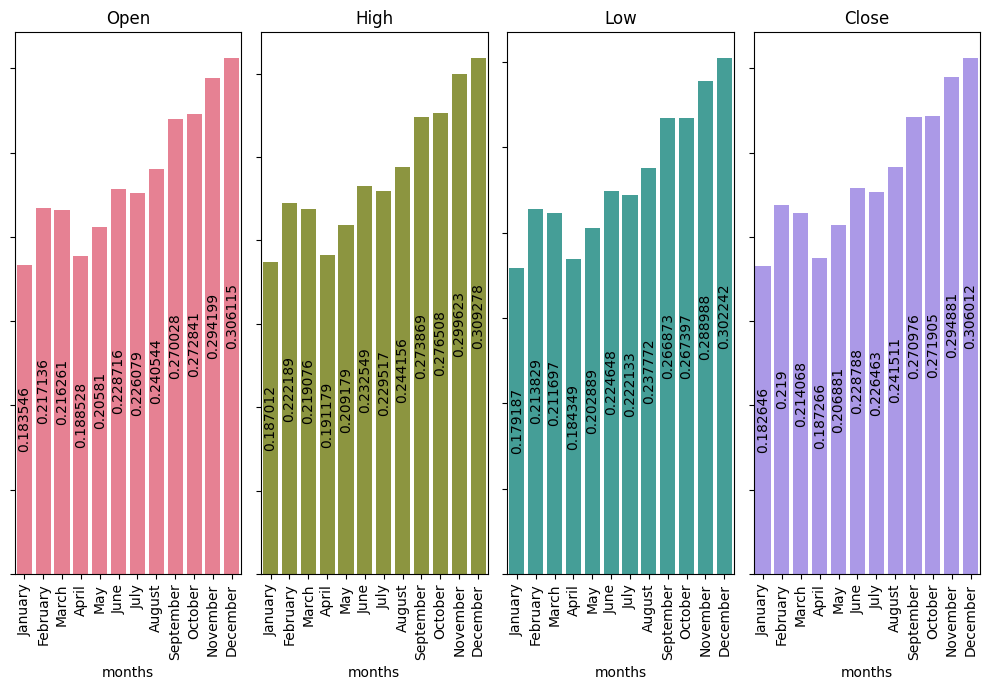

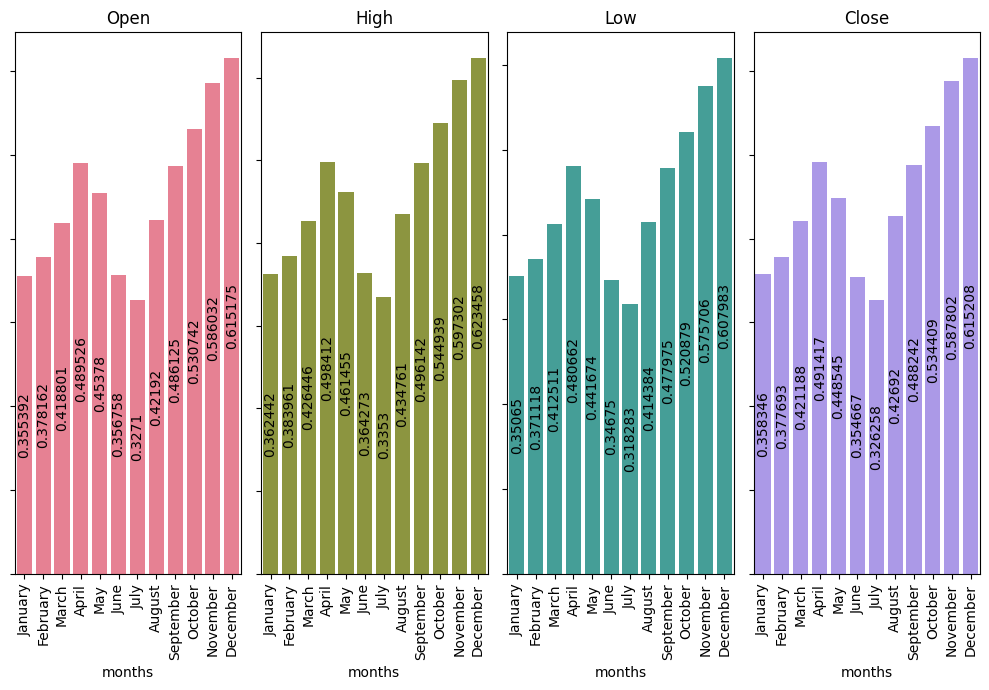

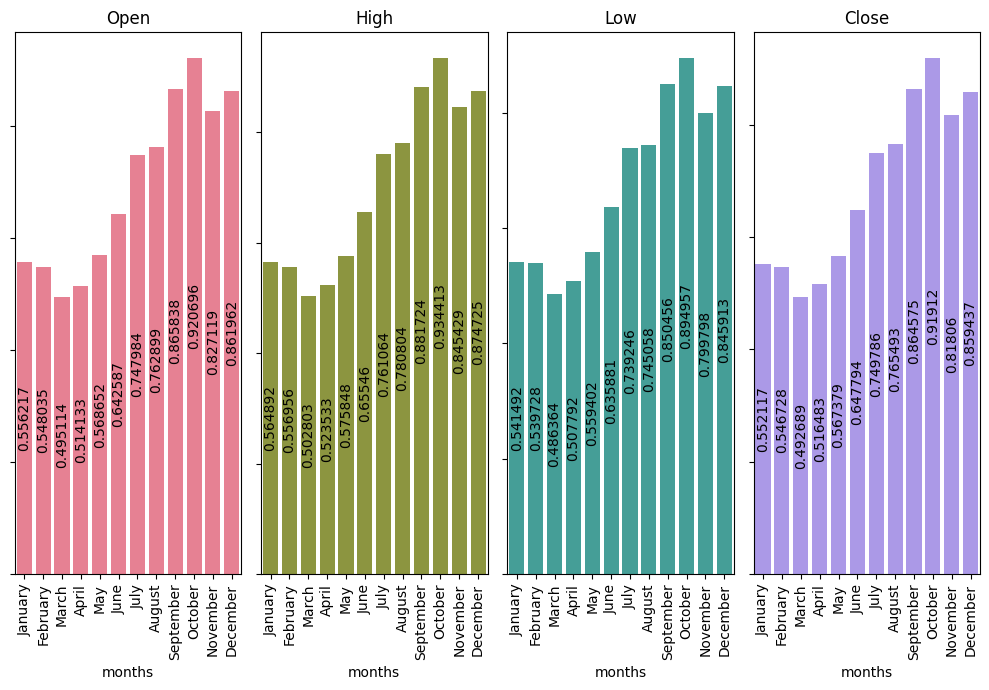

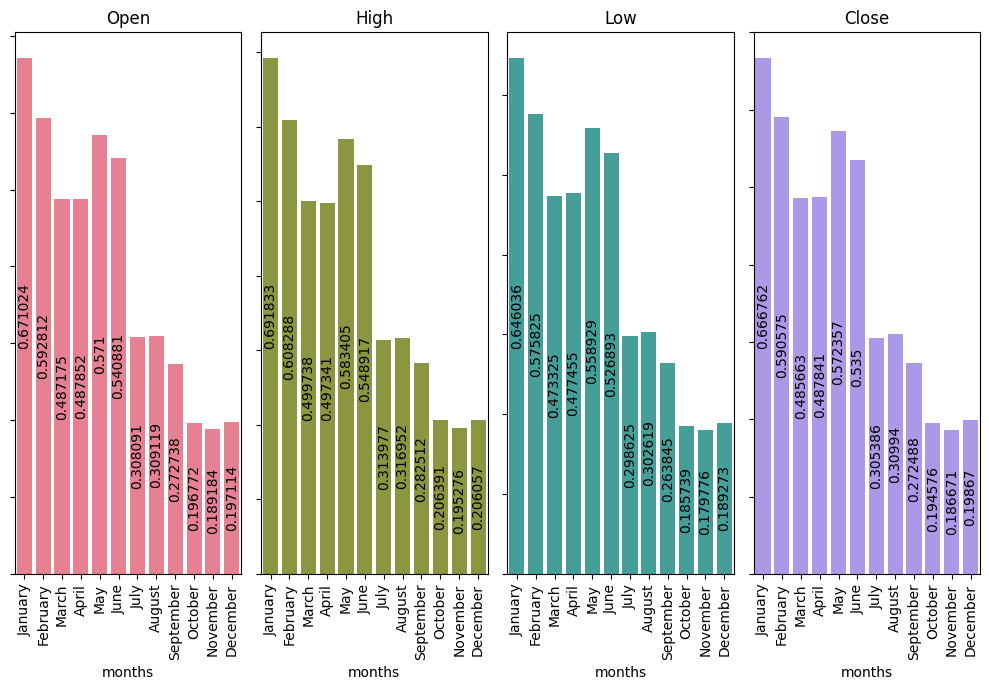

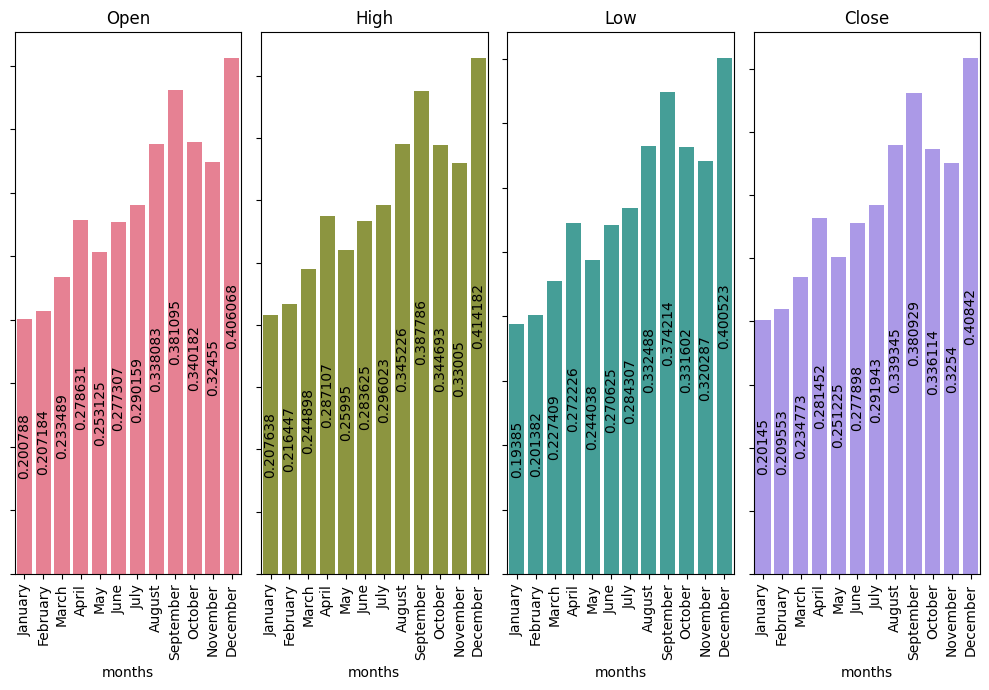

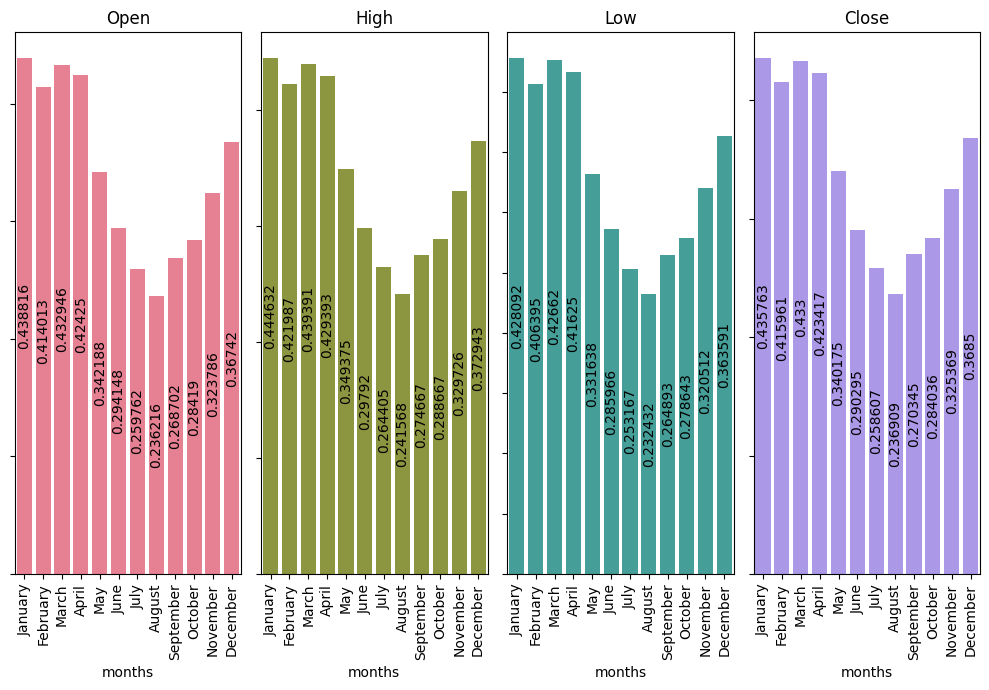

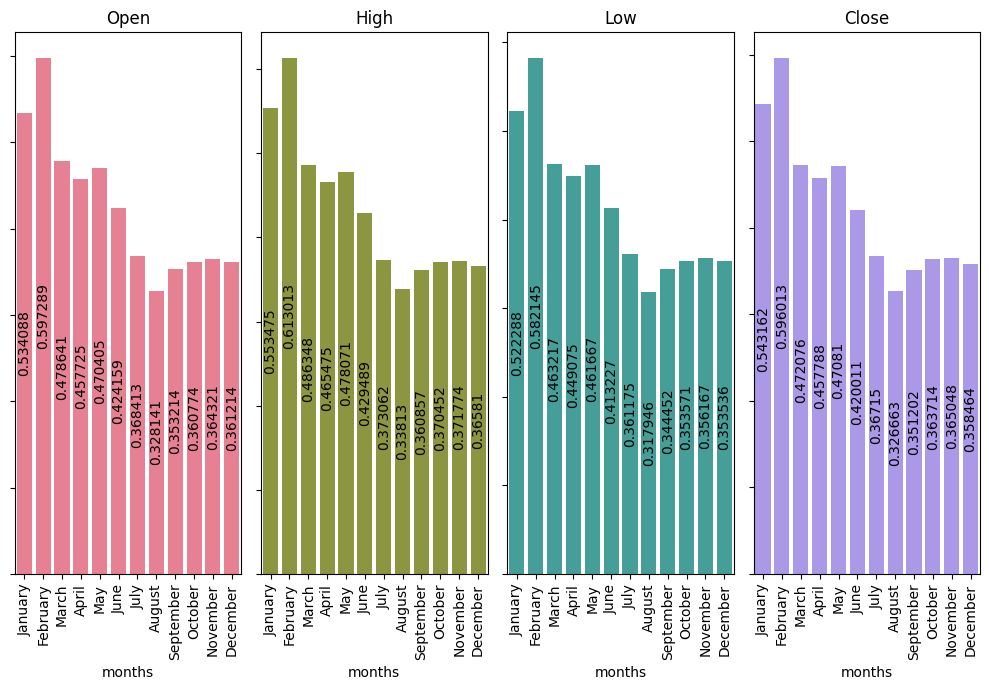

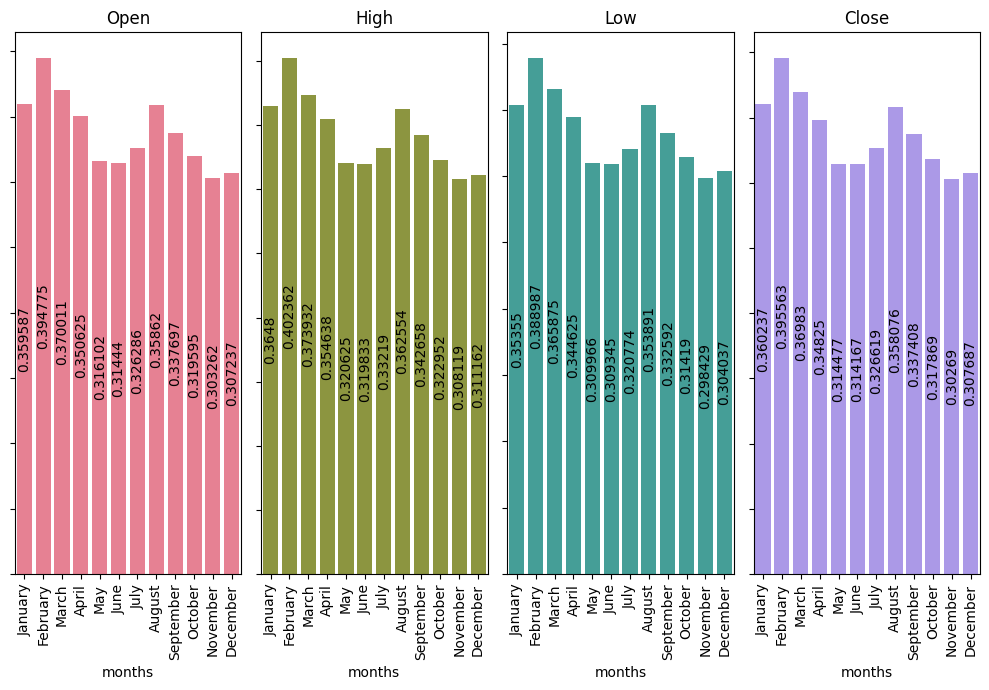

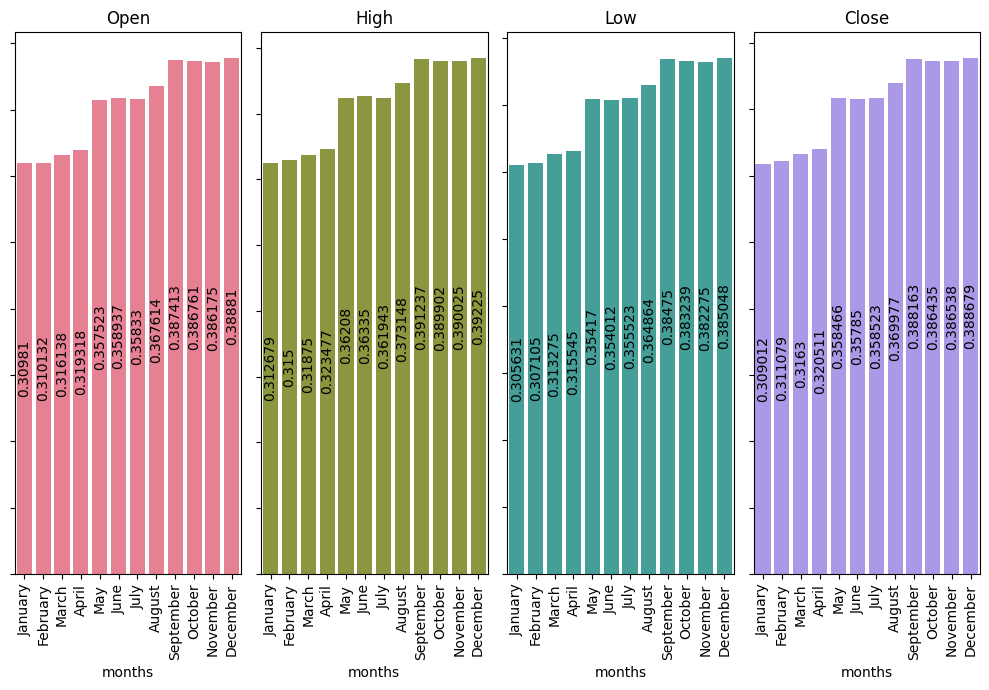

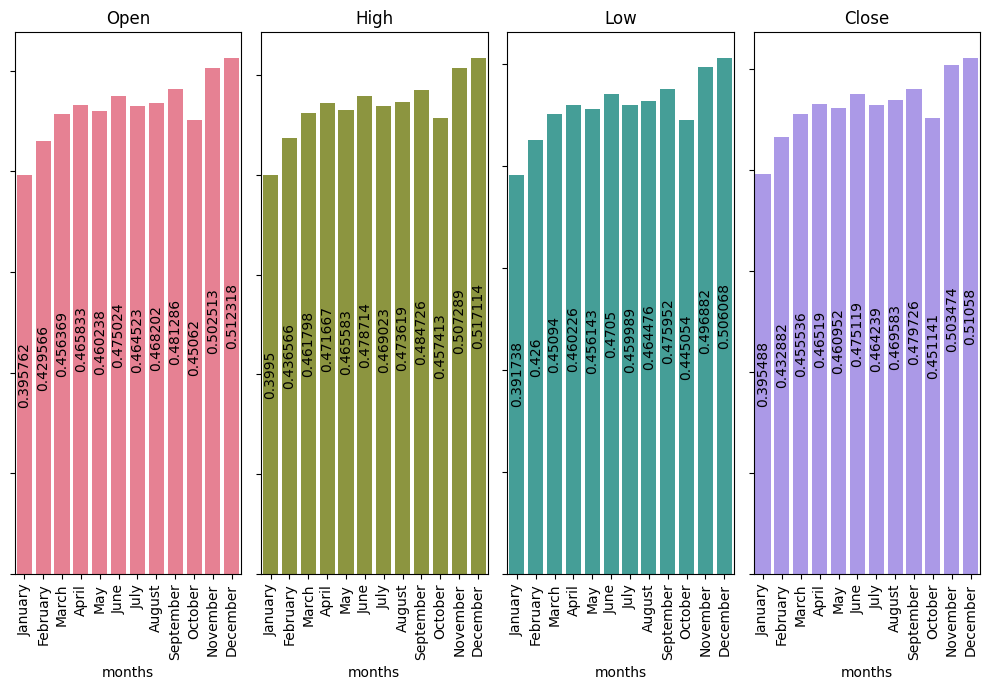

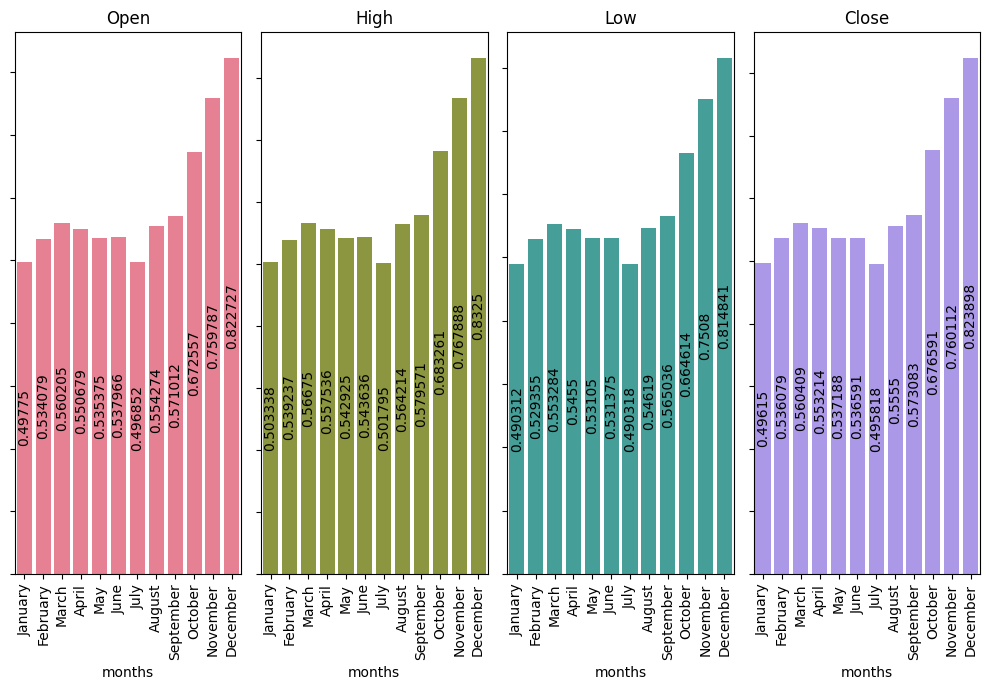

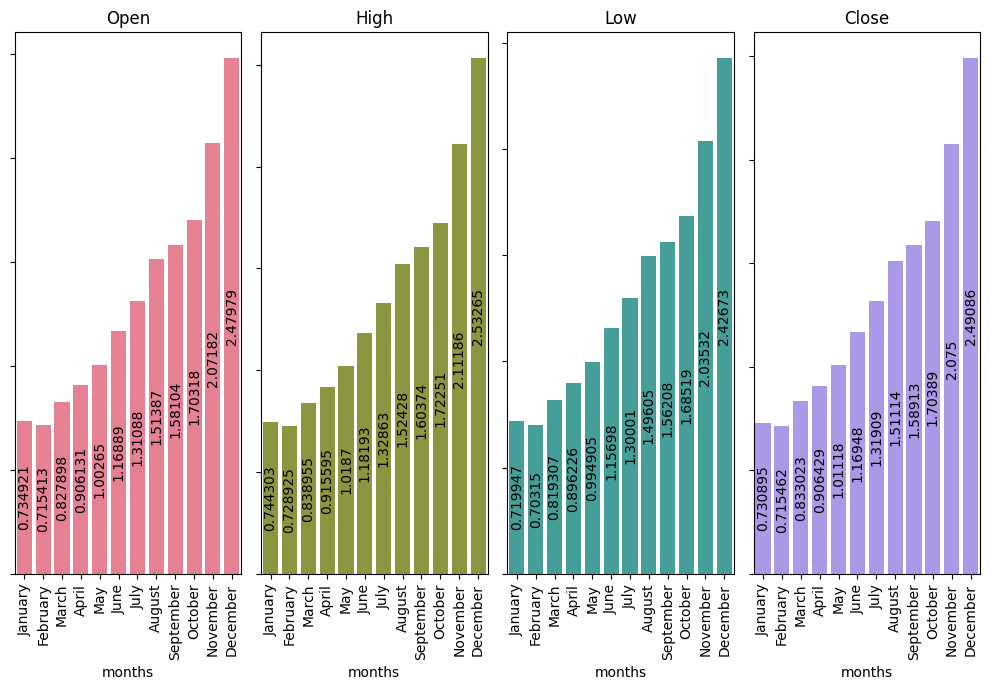

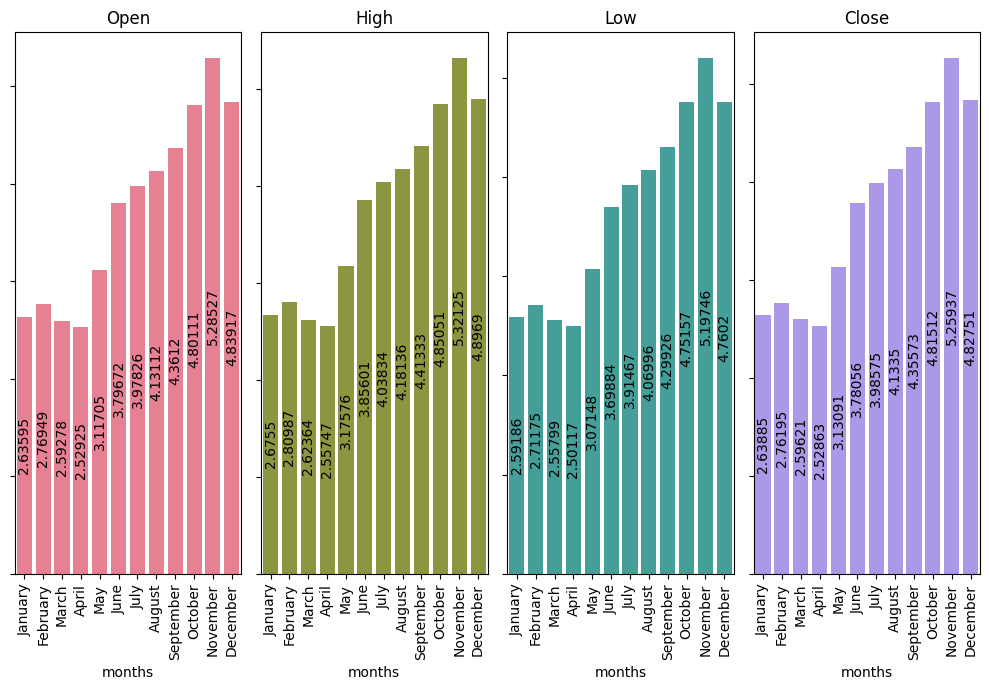

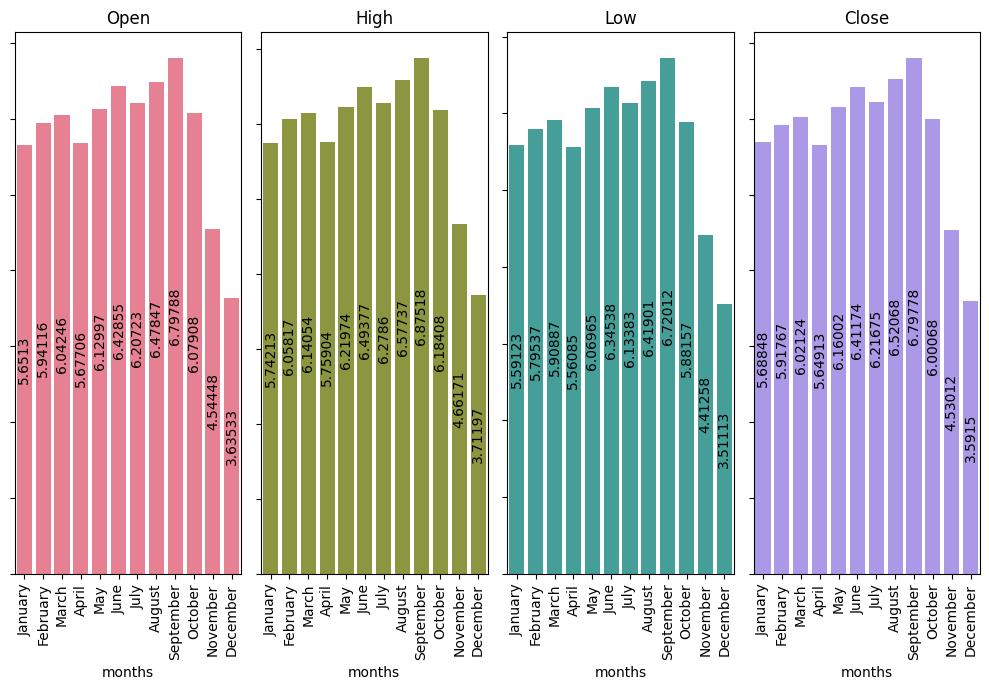

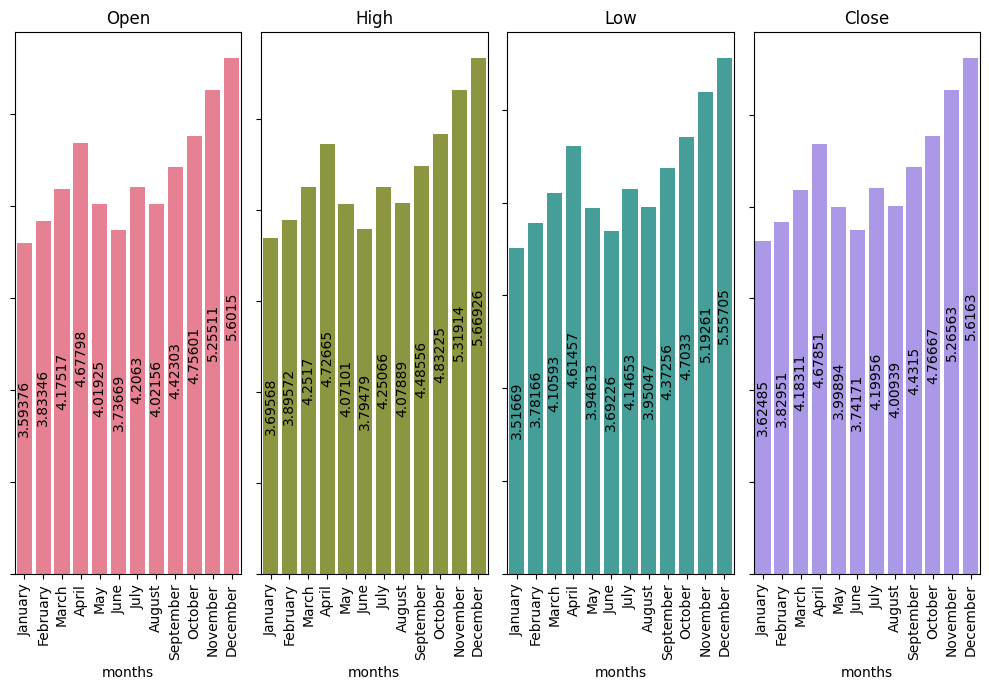

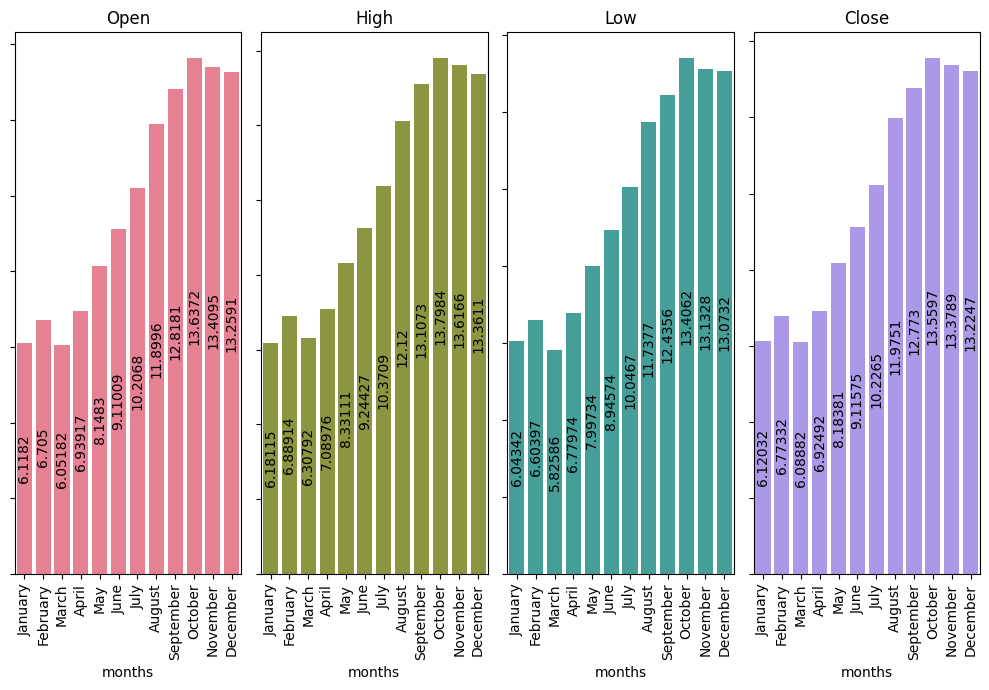

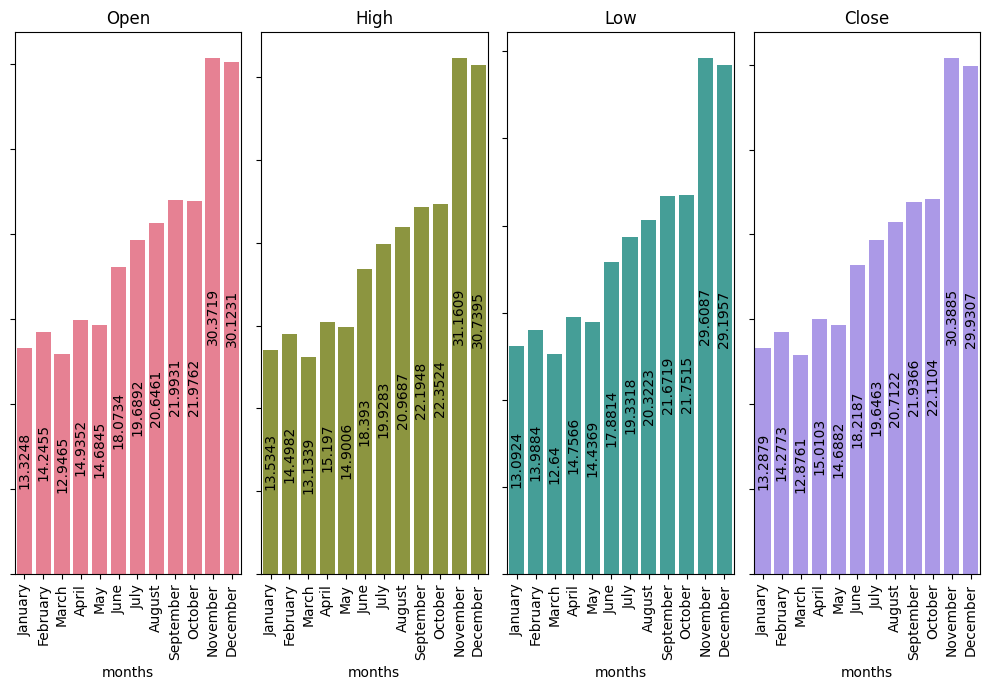

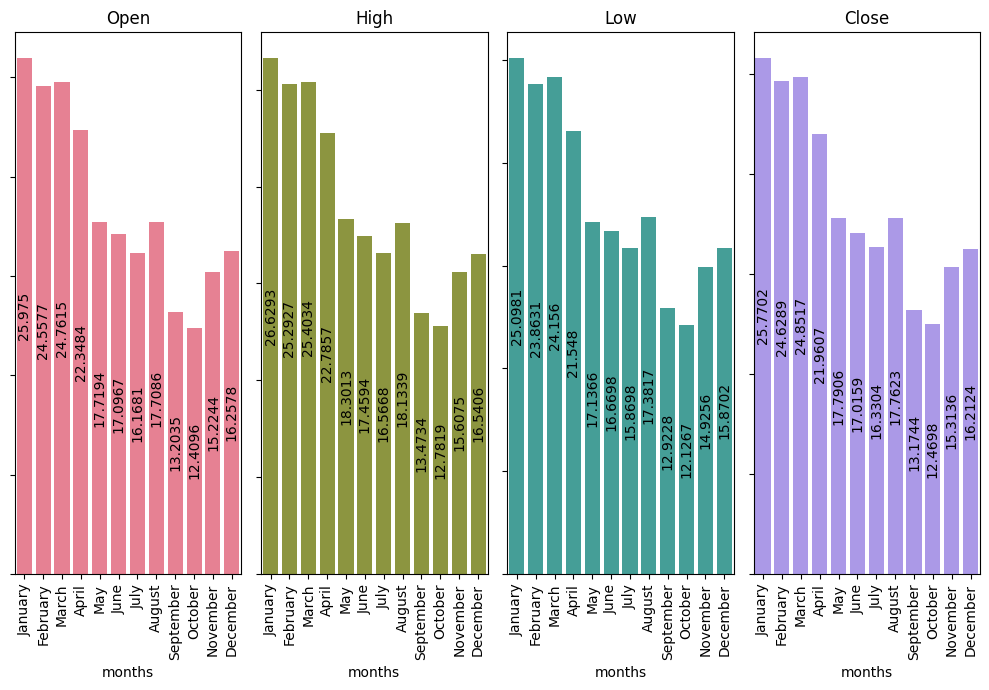

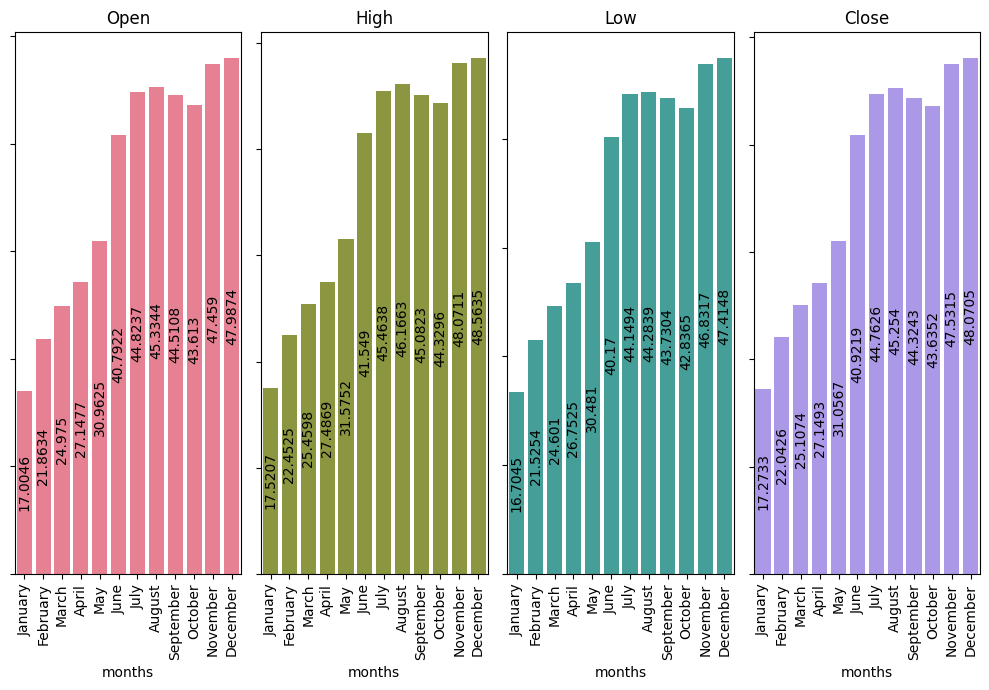

In [10]:
# Function to parse the date column
def convert_date(x):
    date = datetime.strptime(x, "%Y-%m-%d")
    return [date.month, date.year]

months = ["January", "February", "March", "April",
          "May", "June", "July", "August",
          "September", "October", "November", "December"]

df["Year"] = df["Date"].apply(lambda x: convert_date(x)[1])
df["Month"] = df["Date"].apply(lambda x: convert_date(x)[0])

nums = df.columns[1:5].tolist()
years = df["Year"].unique()

# For loop to visualize monthly stocks in each year.
for i in sorted(years):
    display(HTML("<h2>Monthly average stock prices for {}</h2>".format(i)))
    temp_df = df[df["Year"] == i]
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 7))
    grouped = temp_df.groupby("Month")
    
    # Define a color palette
    palette = sns.color_palette("husl", len(nums))  

    for k, j in enumerate(nums):
        mean = pd.DataFrame(grouped[j].mean())
        mean = mean.sort_index(ascending=True)
        dd = {"month": [], j: []}
        for l in range(mean.shape[0]):
            dd["month"].append(months[mean.index[l] - 1])
            dd[j].append(mean.iloc[l, 0])
        dd = pd.DataFrame(dd)

        # Use the color palette in the barplot
        sns.barplot(x=dd['month'], y=dd[j], ax=axes[k], palette=palette[k:k+1])
        for container in axes[k].containers:
            axes[k].bar_label(container, label_type="center", rotation=90)
        axes[k].set_xticklabels(axes[k].get_xticklabels(), rotation=90)
        axes[k].set_title(j)
        axes[k].set_ylabel("")
        axes[k].set_xlabel("months")
        axes[k].set_yticklabels(())

    plt.tight_layout()
    plt.show()

## Data Preprocessing

Since, The EDA is done, let's preprocess the data.

In [11]:
data = df[nums].copy()

cols = data.columns

for i in cols:
    dname = "Target "+i
    data[dname] = data[i].shift(-1)
    
data.dropna(inplace=True)

sc = MinMaxScaler()
scaled = sc.fit_transform(data.values)

x = []

backcandles = 1
for j in range(4):
    x.append([])
    for i in range(backcandles, scaled.shape[0]):
        x[j].append(scaled[i-backcandles:i, j])

x = np.moveaxis(x, [0], [2])

x, yi = np.array(x), np.array(scaled[backcandles:, -4:])
y = np.reshape(yi, (len(yi), 4))

split = int(len(x)*0.8)

x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

## Modelling

Create a Forecasting model architecture.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)         │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ first_layer (LSTM)              │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer (Dense)             │ (None, 4)              │           604 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,604 (365.64 KB)

 Trainable params: 93,604 (365.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.5188e-04 - val_loss: 1.3258e-05
Epoch 2/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0981e-06 - val_loss: 1.3421e-05
Epoch 3/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2322e-06 - val_loss: 1.3549e-05
Epoch 4/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2561e-06 - val_loss: 1.7068e-05
Epoch 5/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5747e-06 - val_loss: 1.4049e-05
Epoch 6/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0960e-06 - val_loss: 1.3903e-05
Epoch 7/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1071e-06 - val_loss: 1.6164e-05
Epoch 8/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4377e-06 - val_loss: 1.3915e-05
Epoch 9/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1892e-06 - val_loss: 2.0954e-05
Epoch 10/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5661e-06 - val_loss: 1.6295e-05
Epoch 11/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

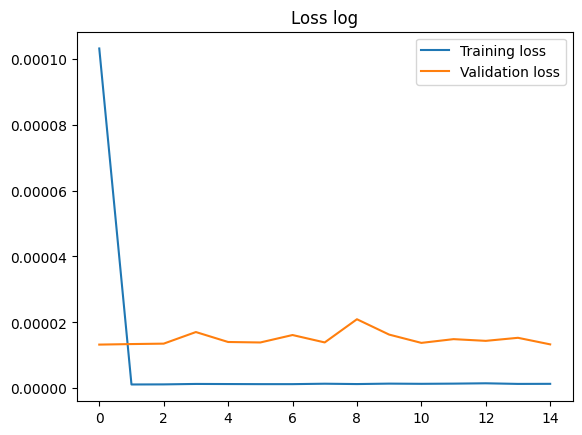

In [12]:
# Using LSTM for our future model training and future predictions
lstm_input = tf.keras.layers.Input(shape=(backcandles, 4), name="lstm_input")
inputs = tf.keras.layers.LSTM(150, name="first_layer")(lstm_input)
inputs = tf.keras.layers.Dense(4, name="dense_layer", activation="linear")(inputs)
model = tf.keras.models.Model(inputs=lstm_input, outputs=inputs)
adam = tf.keras.optimizers.Adam()
model.compile(optimizer=adam, loss="mse")
model.summary()

history = model.fit(x=x_train, y=y_train, batch_size=16, epochs=15, validation_split=0.1)

plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.legend()
plt.title("Loss log")
plt.show()

## Check the test performance of the Forecasting model by Evaluations and Visualizations.

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MSE:  0.0006139021345641935
r2:  0.9888632720257275


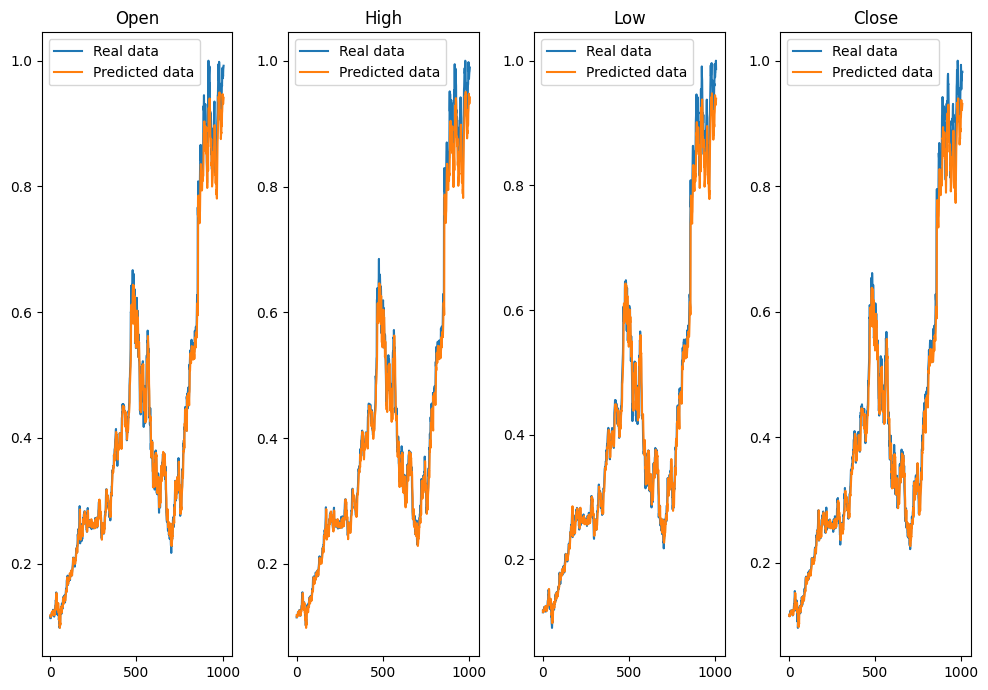

In [13]:
y_pred = model.predict(x_test)

# Model Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE: ", mse)
print("r2: ", r2)

# Model Performance Visualization
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 7))
for i in range(4):
    axes[i].plot(y_test[:, i], label="Real data")
    axes[i].plot(y_pred[:, i], label="Predicted data")
    axes[i].legend()
    axes[i].set_title(nums[i])
plt.tight_layout()
plt.show()